Thymio mini project

In [1]:
!pip install --upgrade tdmclient

object_robot_coords
[8.659383251361973, 4.037936725009219]
object_ground_coords
[ 199.73904648 -411.35100804]
[(209.7390464837317, -396.35100803850014), (209.7390464837317, -426.35100803850014), (189.7390464837317, -426.35100803850014), (189.7390464837317, -396.35100803850014)]


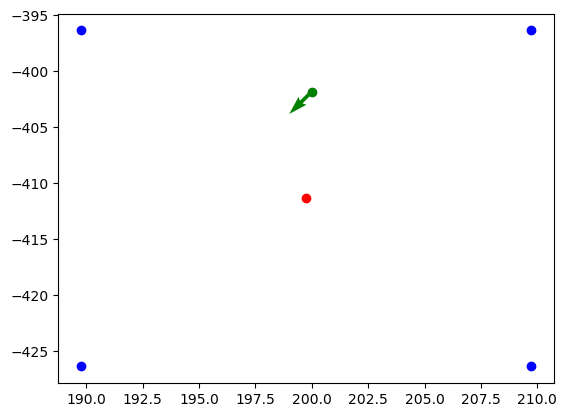

-1.5707963267948966


Node 328bdb70-11b8-49f9-b631-ac6519113084

In [2]:
# import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# import project files
import constants as cst
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf
import geometry as geo

#connect to the robot
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

In [3]:
await node.set_variables({
            'leds.bottom.left': [0, 0, 0],
            'leds.bottom.right': [0, 0, 0],
            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
            'leds.top': [0, 0, 0],
        })

In [4]:
# Set the motor speeds
async def stop_robot():
    """
    Stop the robot. Set the motor speed of each wheel to zero.
    """
    await node.set_variables({
            "motor.right.target": [0],
            "motor.left.target": [0],
        })

async def move_robot(right_speed, left_speed):
    """
    Turn the robot wheels to the given speeds.
    Parameter: - right_speed   : right wheel speed in [thymio speed]
               - left_speed    : left wheel speed in [thymio speed]
    """
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [5]:
# Get the proximity sensor values
async def get_prox_sensors():
    """
    Get the sensor measurements of a the proximity sensors.
    Returns: - prox_sensors    : numpy array of fron proximity sensors measurements
             - detected        : boolean, true if any sensors measured a higher value than threshold
    """
    
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([4000, 2000, 1000, 2000, 4000])) #cst.THRESHOLD_PROX_SENSOR
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected

# Get the motor speed measurement values
async def get_motor_speed_meas():
    """
    Get the motor speed measurements
    Returns: - speed_left_meas    : left wheel speed in [thymio speed]
             - speed_right_meas   : right wheel speed in [thymio speed]
    """
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [6]:
def is_inside(point, obstacles):
    for obstacle in range(len(obstacles)):
        min_x = min(s[0] for s in obstacles[obstacle])
        max_x = max(s[0] for s in obstacles[obstacle])
        min_y = min(s[1] for s in obstacles[obstacle])
        max_y = max(s[1] for s in obstacles[obstacle])
        for summit in range(len(obstacles[obstacle])):
            if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                return True
    return False

In [19]:
# test thymio
# move the robot forward and get prox values.
await move_robot(50, 50)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False


Coordonnées obstacles noirs : [[(501, 455), (827, 455), (827, 0), (501, 0)], [(86, 1076), (575, 1076), (575, 772), (86, 772)]]
Centroid de la goal area : [1633.   559.5]
Vecteur direction du robot : 98 2
Centroid du robot : [151 265]


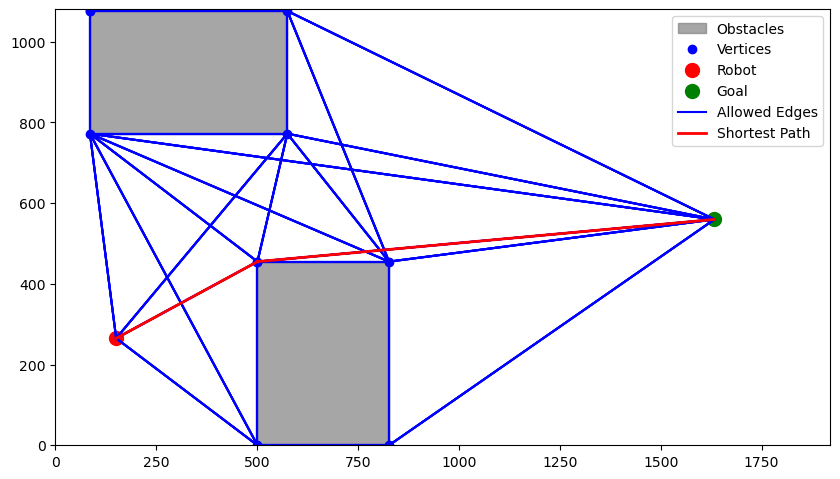

glob nav path : [(151.0, 265.0), (501.0, 455.0), (1633.0, 559.5)]
(8, 14)
[(8, 14), (27, 24), (88, 30)]


In [13]:
#VISION AND GLOBAL NAVIGATION
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

merge_need = True
visualize = True
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)
print("glob nav path :", shortest_path)


def pixels_to_cm(coordinates, pixel_to_cm_ratio=0.05406):
    # Convert each coordinate in the list or individual point
    if isinstance(coordinates[0], (list, tuple)):
        # List of coordinates
        converted_coordinates = [
            (int(x * pixel_to_cm_ratio), int(y * pixel_to_cm_ratio)) for x, y in coordinates
        ]
    else:
        # Single coordinate
        converted_coordinates = (int(coordinates[0] * pixel_to_cm_ratio), int(coordinates[1] * pixel_to_cm_ratio))
    
    return converted_coordinates


def cm_to_pixel(coordinates, cm_to_pixel_ratio=18.4971):
    # Convert each coordinate in the list or individual point
    if isinstance(coordinates[0], (list, tuple)):
        # List of coordinates
        converted_coordinates = [
            (int(x * cm_to_pixel_ratio), int(y * cm_to_pixel_ratio)) for x, y in coordinates
        ]
    else:
        # Single coordinate
        converted_coordinates = (int(coordinates[0] * cm_to_pixel_ratio), int(coordinates[1] * cm_to_pixel_ratio))
    
    return converted_coordinates



shortest_path = pixels_to_cm(shortest_path)


robot_centroid = pixels_to_cm(robot_centroid)
print(robot_centroid)
print(shortest_path)

#obstacles = np.array(obstacles)

1 rotation
Kalman:  8.000000000009036 14.000000000000068 0.02040533068804504 13.86001386001386 12.320012320012319
[0.02040533] [0.48447793] [0.4640726]
[(27, 24), (88, 30)]
2 rotation
Kalman:  10.307005790477884 13.98398625903929 0.07781811271426467 6.2700014025464395 4.168998941842473
[0.07781811] [0.54042907] [0.46261096]
[(27, 24), (88, 30)]
3 rotation
Kalman:  11.375347340436896 14.084571867499251 0.14872292426991868 3.3930765151324165 0.689611730930968
[0.14872292] [0.565474] [0.41675107]
[(27, 24), (88, 30)]
4 rotation
Kalman:  11.847348622968632 14.167610744224376 0.2325749853458473 2.2825000886652136 -0.6875032663988561
[0.23257499] [0.57559383] [0.34301884]
[(27, 24), (88, 30)]
5 rotation
Kalman:  12.039423599838397 14.218701276346888 0.32272323439465783 1.8916300070577585 -1.2483172132427849
[0.32272323] [0.5790454] [0.25632216]
[(27, 24), (88, 30)]
6 rotation
Kalman:  12.114189203243567 14.246747071772951 0.41419871008351816 1.6743144151636495 -1.4285857581830892
[0.41419871

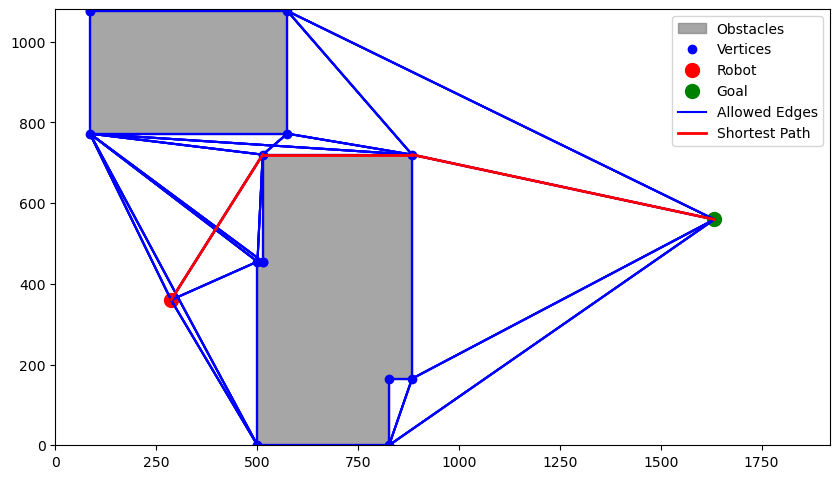

glob nav path : [(287.0, 360.0), (514.0, 720.0), (884.0, 720.0), (1633.0, 559.5)]
camera measurements:  (15, 19) 0.2741674511196588
centroid camera:  (15, 19)
camera fin: [(27, 38), (47, 38), (88, 30)]
32 rotation
Kalman:  14.999997953924906 19.000100276110487 0.2748261584434657 -2.082213033667559 -1.5323843393858998
[0.27482616] [1.00747761] [0.73265145]
[(27, 38), (47, 38), (88, 30)]
33 rotation
Kalman:  14.375902382976028 18.824233768825753 0.2721270249486957 -0.8117666149045935 -1.5620484681301803
[0.27212702] [0.98858329] [0.71645627]
[(27, 38), (47, 38), (88, 30)]
34 rotation
Kalman:  14.048938026157343 18.735856650204973 0.3147294127576097 0.5372243798539711 -1.5810430410742102
[0.31472941] [0.97891178] [0.66418237]
[(27, 38), (47, 38), (88, 30)]
35 rotation
Kalman:  13.92057970276536 18.69413568187255 0.3868912609744861 1.1568125586165445 -1.555590913368753
[0.38689126] [0.97534192] [0.58845066]
[(27, 38), (47, 38), (88, 30)]
36 rotation
Kalman:  13.877876090017217 18.676010533

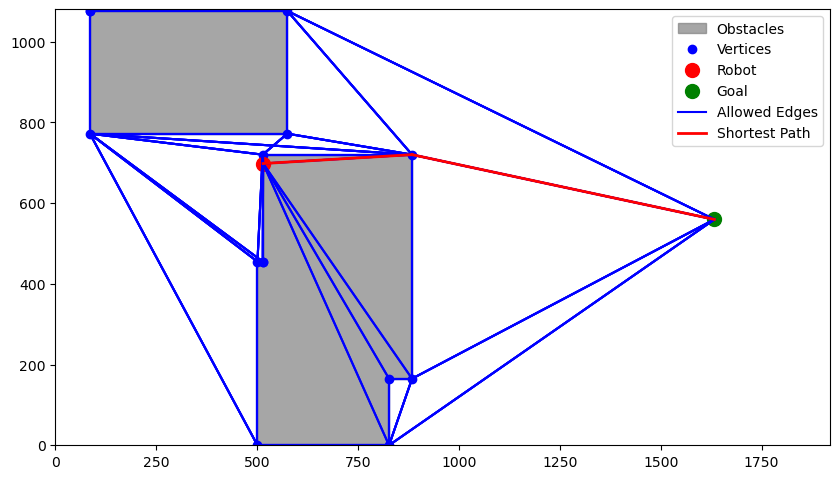

glob nav path : [(515.0, 698.0), (884.0, 720.0), (1633.0, 559.5)]
camera measurements:  (27, 37) 0.9129077216126865
centroid camera:  (27, 37)
camera fin: [(47, 38), (88, 30)]
74 rotation
Kalman:  27.000077269377872 37.00019717510448 0.9134812625177039 0.3636981965248939 0.7769723360988333
[0.91348126] [0.04994875] [-0.86353251]
[(47, 38), (88, 30)]
75 rotation
Kalman:  27.111246162115975 37.14428736535085 0.8885045766896182 -0.5913718916930606 1.0351816871418738
[0.88850458] [0.04299843] [-0.84550615]
[(47, 38), (88, 30)]
76 rotation
Kalman:  27.14734848131375 37.18895476428722 0.8258561783907892 -1.2437826512903452 1.37985642803065
[0.82585618] [0.04083054] [-0.78502564]
[(47, 38), (88, 30)]
77 rotation
Kalman:  27.154163159090324 37.195875173164715 0.7429726382951385 -1.4947397048194513 1.4787694299346683
[0.74297264] [0.04049641] [-0.70247623]
[(47, 38), (88, 30)]
78 rotation
Kalman:  27.158502637340483 37.200381312060244 0.6533684466651393 -1.522709858289326 1.584591157214382
[0.6

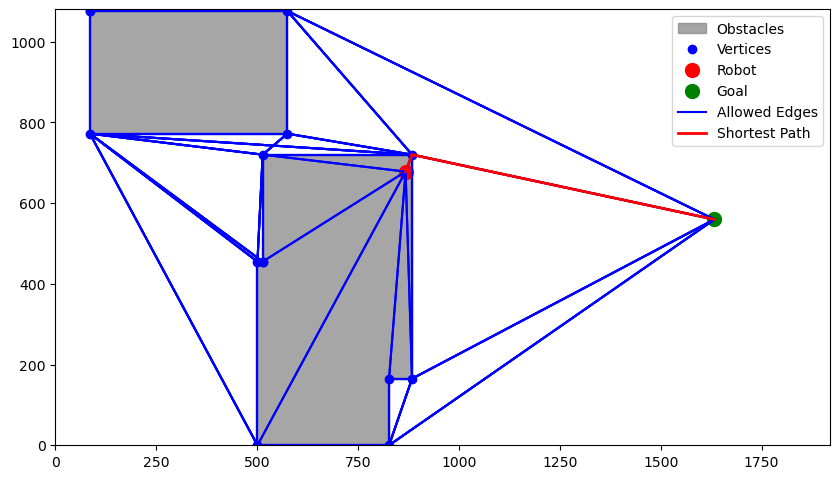

glob nav path : [(868.0, 678.0), (884.0, 720.0), (1633.0, 559.5)]
camera measurements:  (46, 36) 0.0
centroid camera:  (46, 36)
camera fin: [(88, 30)]
113 rotation
Kalman:  46.00032176410838 36.00003596043511 0.0003913598473932814 1.2264928750887316 1.3371758093014439
[0.00039136] [-0.14189897] [-0.14229033]
[(88, 30)]
114 rotation
Kalman:  46.46724657418067 36.00025967539261 -0.008800784995099026 0.5473539820759507 1.2226796053568953
[-0.00880078] [-0.14347783] [-0.13467705]
[(88, 30)]
115 rotation
Kalman:  46.68891998491284 36.000383751706416 -0.05384492954762679 -0.9428322014340825 1.4170316799274107
[-0.05384493] [-0.14424006] [-0.09039514]
[(88, 30)]
116 translation
Kalman:  46.69791947245148 35.998434296068595 -0.059318734180545646 -0.3604406130030805 0.5756429955046171
trabslation: [(88, 30)]
Error: [41.73539349]
117 translation
Kalman:  46.95642038076864 35.984710891800894 -0.07907123574662354 0.9840020584077799 1.3925755526220485
trabslation: [(88, 30)]
Error: [41.47761074]
11

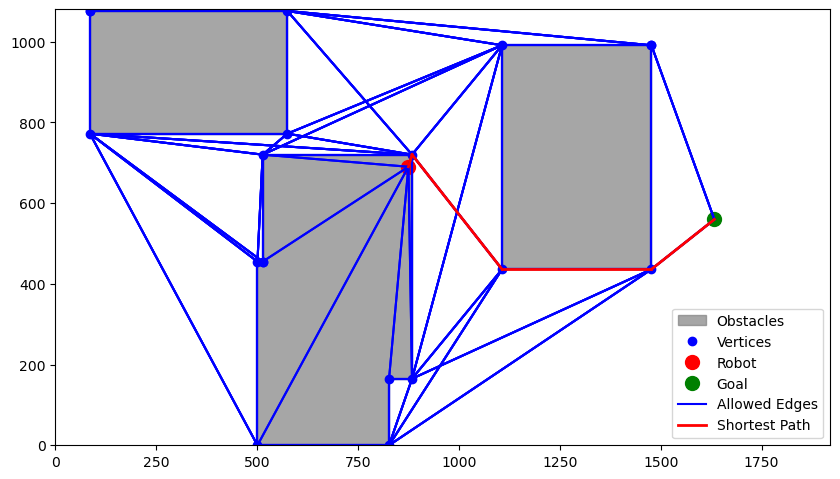

glob nav path : [(875.0, 690.0), (884.0, 720.0), (1107.0, 436.0), (1477.0, 436.0), (1633.0, 559.5)]
camera measurements:  (47, 37) -0.3715178551467089
centroid camera:  (47, 37)
camera fin: [(47, 38), (59, 23), (79, 23), (88, 30)]
135 rotation
Kalman:  47.00029331176533 36.99996234754179 -0.3712503579523539 -2.1767496908307535 -2.1033892537601098
[-0.37125036] [1.57108963] [1.94233999]
[(47, 38), (59, 23), (79, 23), (88, 30)]
136 rotation
Kalman:  46.29253247726305 37.2755526453334 -0.362463648568395 -0.8489186835412874 -1.7924675970626915
[-0.36246365] [0.79725574] [1.15971939]
[(47, 38), (59, 23), (79, 23), (88, 30)]
137 rotation
Kalman:  45.94398573905924 37.410346753633426 -0.31527047895322463 0.5568359438814938 -1.670532126289481
[-0.31527048] [0.50925133] [0.82452181]
[(47, 38), (59, 23), (79, 23), (88, 30)]
138 rotation
Kalman:  45.81793142193791 37.451230759155216 -0.23926930515621153 1.2662438449044673 -1.589872844101605
[-0.23926931] [0.43463659] [0.6739059]
[(47, 38), (59, 2

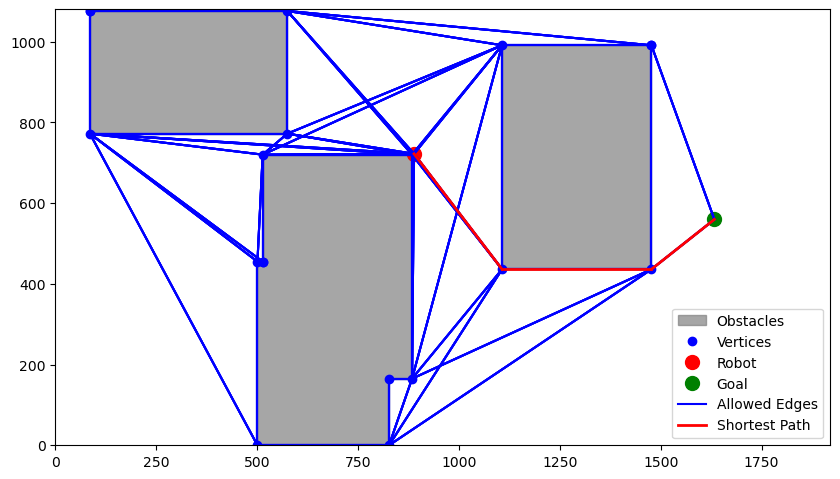

glob nav path : [(889.0, 722.0), (1107.0, 436.0), (1477.0, 436.0), (1633.0, 559.5)]
camera measurements:  (48, 39) 0.3430239404207034
centroid camera:  (48, 39)
camera fin: [(59, 23), (79, 23), (88, 30)]
150 rotation
Kalman:  48.00020790436943 39.0003063815074 0.3439427398941375 1.3138516993495155 1.6616506502779502
[0.34394274] [-0.96852674] [-1.31246948]
[(59, 23), (79, 23), (88, 30)]
151 rotation
Kalman:  48.46406882308488 39.166548809139194 0.32201903051517156 -0.1044620887354828 1.3868432050033883
[0.32201903] [-0.99321865] [-1.31523768]
[(59, 23), (79, 23), (88, 30)]
152 rotation
Kalman:  48.636714500185995 39.22463759208201 0.2652678676357816 -0.9203943635976863 1.4471927994321123
[0.26526787] [-1.00237925] [-1.26764712]
[(59, 23), (79, 23), (88, 30)]
153 rotation
Kalman:  48.710790596303006 39.24471476324644 0.18608682272863414 -1.3370768829956954 1.606446225767245
[0.18608682] [-1.00618783] [-1.19227465]
[(59, 23), (79, 23), (88, 30)]
154 rotation
Kalman:  48.73250710941778 39

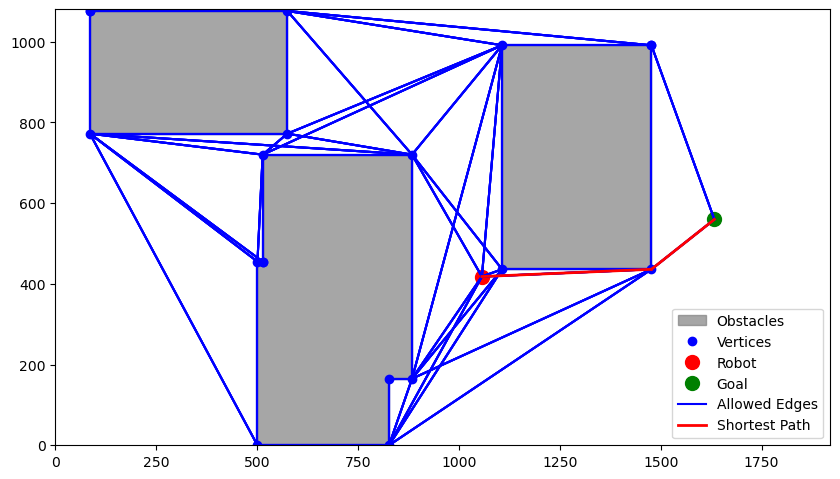

glob nav path : [(1057.0, 418.0), (1477.0, 436.0), (1633.0, 559.5)]
camera measurements:  (57, 22) -0.7213831855631042
centroid camera:  (57, 22)
camera fin: [(79, 23), (88, 30)]
193 rotation
Kalman:  57.00010321973034 21.999697841837847 -0.7227897653676184 1.7887124150029459 1.2213411572233284
[-0.72278977] [0.0454372] [0.76822696]
[(79, 23), (88, 30)]
194 rotation
Kalman:  57.365189410903525 21.677540839027515 -0.6929356968247725 1.5289917300889853 -0.28838347501481976
[-0.6929357] [0.06105049] [0.75398618]
[(79, 23), (88, 30)]
195 rotation
Kalman:  57.50454052483459 21.561494566564644 -0.6274887561747576 1.6030028608425828 -1.0258773448321077
[-0.62748876] [0.06682173] [0.69431048]
[(79, 23), (88, 30)]
196 rotation
Kalman:  57.57506273636936 21.510773827072363 -0.5439390312388968 1.6659817023045729 -1.3434911226685473
[-0.54393903] [0.06939739] [0.61333642]
[(79, 23), (88, 30)]
197 rotation
Kalman:  57.61404497433941 21.488124553949678 -0.4554712020307595 1.5881242476141797 -1.43094

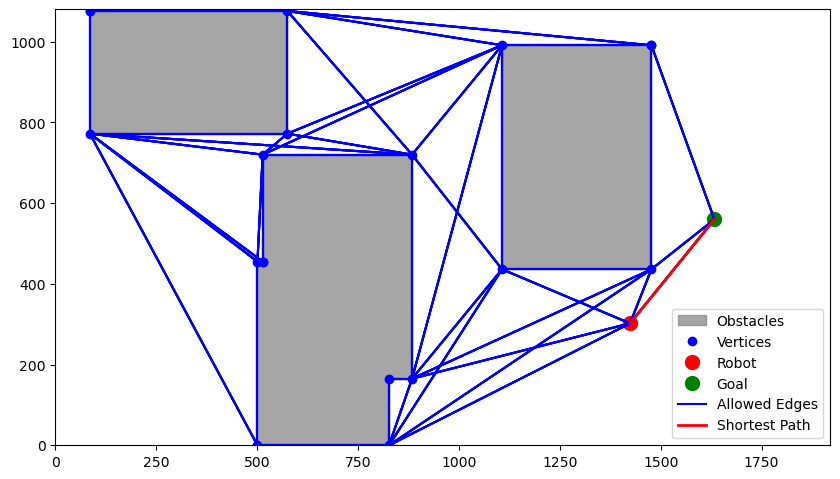

glob nav path : [(1424.0, 302.0), (1633.0, 559.5)]
camera measurements:  (76, 16) -0.2945463829994291
centroid camera:  (76, 16)
camera fin: [(88, 30)]
233 rotation
Kalman:  76.0005086180413 16.000317324091355 -0.2905405636601065 0.5366206527450523 2.1025308432567615
[-0.29054056] [0.8621798] [1.15272036]
[(88, 30)]
234 rotation
Kalman:  76.3996064980448 15.880774200744877 -0.3107979057159625 0.9663020497040591 -0.007618925511496233
[-0.31079791] [0.88302113] [1.19381903]
[(88, 30)]
235 rotation
Kalman:  76.5278101437183 15.838153362463885 -0.2623143868943105 1.3530357595414002 -0.9519975120415208
[-0.26231439] [0.88994085] [1.15225524]
[(88, 30)]
236 rotation
Kalman:  76.58184174740788 15.823622799993004 -0.18607101597415712 1.502476577697523 -1.31525365912436
[-0.18607102] [0.8927498] [1.07882081]
[(88, 30)]
237 rotation
Kalman:  76.60925395325732 15.818694038051158 -0.10003464770090456 1.5596545091480518 -1.454147182840911
[-0.10003465] [0.89409345] [0.99412809]
[(88, 30)]
238 rotat

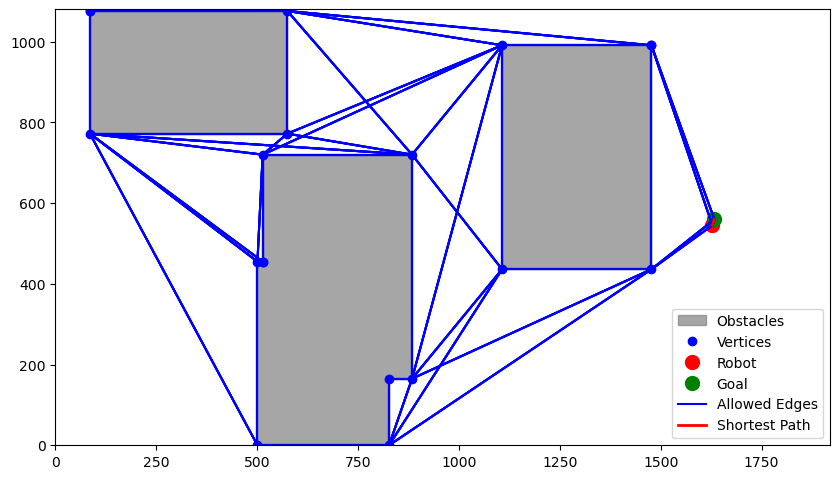

glob nav path : [(1628.0, 545.0), (1633.0, 559.5)]
camera measurements:  (88, 29) 0.7509290623979403
centroid camera:  (88, 29)
camera fin: []
273 rotation
je suis au goal


In [14]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

#intermediate_goals = [(0, 10), (-10, 10), (-10, 0), (0,0)]
#intermediate_goals = [(56, 34), (66, 34), (87, 26)]
#robot = [(34.0,28.0)]
#robot_orientation = 1.6
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
#robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
#await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    # test if local (with proximity)
        
    if(detected):
        await stop_robot()
        global_state = 'local_avoidance'

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    #print(speed_right_meas, speed_left_meas, "  ", robot_speed[0], robot_speed[1])
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    
    #speed_right_meas = robot_speed[0] * speed_correction
    #speed_left_meas = robot_speed[1] * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    #print(dt, time.time(), old_time)
    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        #printkal = False
    #print("Kalman Sigma: ", Kfilter.Sigma)
    #print("Kalman y: ", Kfilter.y)
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = geo.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        print(intermediate_goals)
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 1.0 #32 #14
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 1.0 #12.5

    elif global_state == 'translation':
        
        print("trabslation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 10.0):     #translation condition
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            #intermediate_goals.pop(0)
            global_state = 'camera'
            continue
            
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = geo.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = 'camera'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)
        print("glob nav path :", shortest_path)
        
        
        shortest_path = pixels_to_cm(shortest_path)
        robot_centroid = pixels_to_cm(robot_centroid) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        #print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = 'rotation'
        continue
        
        
        
    elif global_state == 'local_avoidance':
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = cm_to_pixel(Object)
        
        print("OBject:", Object)
        print("avant append:", obstacles)
        obstacles.append(Object)
        print("après append:", obstacles)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-50, -50)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
            await client.sleep(0.4)
        
        global_state = "camera"
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [12]:
await stop_robot()